In [1]:
import tensorflow as tf
import segmentation_models as sm
import glob
import os
import cv2
import numpy as np
import pandas as pd 
import random

import matplotlib.pyplot as plt
import keras
from tqdm.notebook import tqdm

from keras.utils import normalize
from keras.metrics import MeanIoU
print(tf.config.list_physical_devices('GPU'))

Segmentation Models: using `keras` framework.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
size_x = 256
size_y = 256
n_classes = 2

In [3]:
train_images=[]
for directory_path in glob.glob('maize/images/'):
    for img_path in tqdm(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path,1)
        img = cv2.resize(img, (size_x,size_y))
        train_images.append(img)
train_images = np.array(train_images)

  0%|          | 0/130 [00:00<?, ?it/s]

In [4]:
train_images.shape

(130, 256, 256, 3)

In [5]:
train_masks=[]
for directory_path in glob.glob('maize/masks/'):
    for img_path in tqdm(glob.glob(os.path.join(directory_path, "*.JPG"))):
        img = cv2.imread(img_path,0)
        img = img/255
        img = cv2.resize(img, (size_x,size_y), interpolation=cv2.INTER_NEAREST)
        train_masks.append(img)
train_masks = np.array(train_masks)

  0%|          | 0/130 [00:00<?, ?it/s]

In [6]:
train_masks = (train_masks>0.5).astype(int)

In [7]:
np.unique(train_masks)

array([0, 1])

In [8]:
train_masks.shape

(130, 256, 256)

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
n,h,w = train_masks.shape #(165, 128, 128)
train_masks_reshaped = train_masks.reshape(-1,1) #(2703360, 1)
train_masks_reshaped_encoded = le.fit_transform(train_masks_reshaped)
train_masks_encoded_original = train_masks_reshaped_encoded.reshape(n,h,w) # (165, 128, 128)

np.unique(train_masks_encoded_original)

C:\Users\ASUS\anaconda3\envs\gpuenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([0, 1], dtype=int64)

In [10]:
train_masks_input = np.expand_dims(train_masks_encoded_original,axis=3)

In [11]:
train_masks_input.shape

(130, 256, 256, 1)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.1, random_state=0)


In [13]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [14]:
n_classes = 2
activation = 'softmax'
LR = 0.0001
optim = keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.05,0.95]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


# Model 1

In [15]:
##Model 1
BACKBONE1 = 'seresnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

X_train1 = preprocess_input1(X_train) #(148, 256, 256, 3) --> shape of X_train and X_train1

X_test1 = preprocess_input1(X_test) #(17, 256, 256, 3) for both X_test and X_test1

model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optim, total_loss, metrics = metrics)
print(model1.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [16]:
'''
%%time
history1 = model1.fit(X_train1,
                     y_train_cat,
                     batch_size=4,
                     epochs=50,
                     verbose=1,
                     validation_data=(X_test1,y_test_cat))
'''

'\n%%time\nhistory1 = model1.fit(X_train1,\n                     y_train_cat,\n                     batch_size=4,\n                     epochs=50,\n                     verbose=1,\n                     validation_data=(X_test1,y_test_cat))\n'

In [17]:
#np.save('seresnet18_history.npy',history1.history)
history1=np.load('seresnet18_history.npy',allow_pickle='TRUE').item()


In [18]:
#model1.save('maize/saved_models/seresnet18_unet.hdf5')

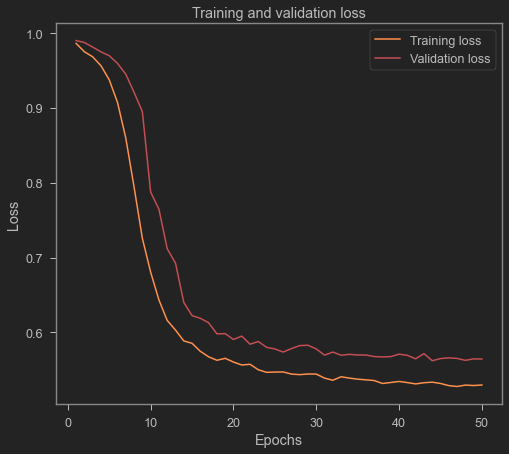

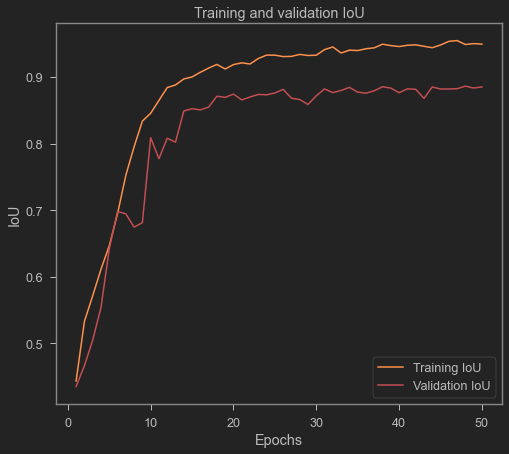

In [19]:
#plot the training and validation accuracy and loss at each epoch
#plt.style.use('classic')

loss = history1['loss']
val_loss = history1['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1['iou_score']
val_acc = history1['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(loc='lower right')
plt.show()

In [20]:
#del model1

# Model 2

In [21]:
##Model 2
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)
model2.compile(optim, total_loss, metrics = metrics)
print(model2.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [22]:
'''
%%time
history2 = model2.fit(X_train2,
                     y_train_cat,
                     batch_size=4,
                     epochs=50,
                     verbose=1,
                     validation_data=(X_test2,y_test_cat))
'''

'\n%%time\nhistory2 = model2.fit(X_train2,\n                     y_train_cat,\n                     batch_size=4,\n                     epochs=50,\n                     verbose=1,\n                     validation_data=(X_test2,y_test_cat))\n'

In [23]:
#model2.save('maize/saved_models/inceptionv3_unet.hdf5')

In [24]:
#np.save('inceptionv3_history.npy',history2.history)
history2=np.load('inceptionv3_history.npy',allow_pickle='TRUE').item()

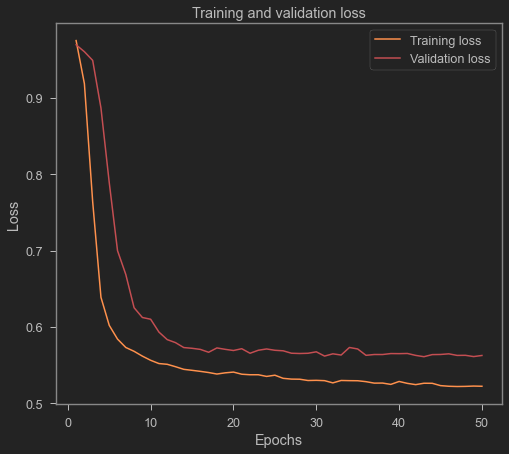

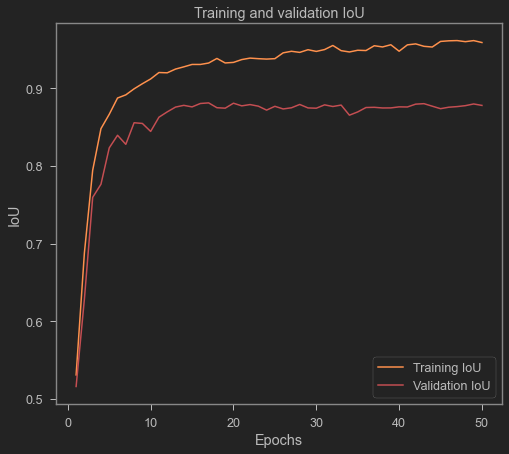

In [25]:
#plot the training and validation accuracy and loss at each epoch
loss = history2['loss']
val_loss = history2['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2['iou_score']
val_acc = history2['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(loc='lower right')
plt.show()


In [26]:
#del model2

# Model 3

In [27]:
##Model 3
BACKBONE3 = 'vgg19'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)
model3.compile(optim, total_loss, metrics = metrics)
print(model3.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [28]:
'''
%%time
history3 = model3.fit(X_train3,
                     y_train_cat,
                     batch_size=4,
                     epochs=50,
                     verbose=1,
                     validation_data=(X_test3,y_test_cat))
'''

'\n%%time\nhistory3 = model3.fit(X_train3,\n                     y_train_cat,\n                     batch_size=4,\n                     epochs=50,\n                     verbose=1,\n                     validation_data=(X_test3,y_test_cat))\n'

In [29]:
#model3.save('maize/saved_models/vgg19_unet.hdf5')

In [30]:
#np.save('vgg19_history.npy',history3.history)
history3=np.load('vgg19_history.npy',allow_pickle='TRUE').item()

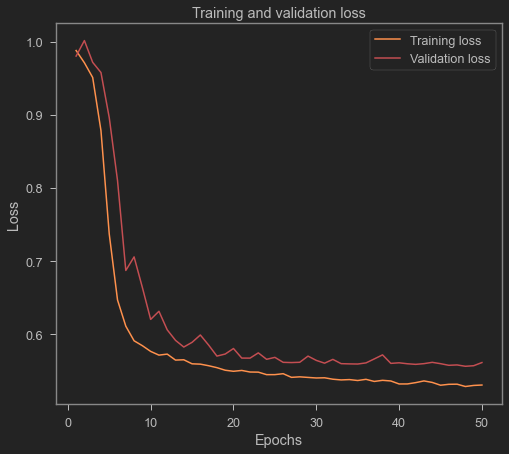

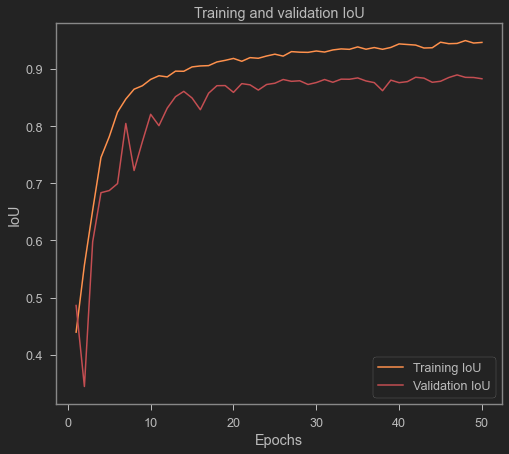

In [31]:
#plot the training and validation accuracy and loss at each epoch
loss = history3['loss']
val_loss = history3['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3['iou_score']
val_acc = history3['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(loc='lower right')
plt.show()


In [32]:
#del model3

# Evaluation

In [33]:
%%time
from keras.models import load_model

model1 = load_model('maize/saved_models/seresnet18_unet.hdf5', compile=False)
model2 = load_model('maize/saved_models/inceptionv3_unet.hdf5', compile=False)
model3 = load_model('maize/saved_models/vgg19_unet.hdf5', compile=False)

Wall time: 3.06 s


In [34]:
%%time
#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)

y_pred2=model2.predict(X_test2)
y_pred2_argmax=np.argmax(y_pred2, axis=3)

y_pred3=model3.predict(X_test3)
y_pred3_argmax=np.argmax(y_pred3, axis=3)

Wall time: 12.6 s


In [35]:
acc=[]
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
acc.append(IOU_keras.result().numpy())
print("Mean IoU for Model1: SEResNet18 = ", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[0,1])

print("IoU for Background is: ", class1_IoU)
print("IoU for Maize is: ", class2_IoU)
print("-------------------------------------------")
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred2_argmax)
acc.append(IOU_keras.result().numpy())
print("Mean IoU for Model2: InceptionV3 = ", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[0,1])

print("IoU for Background is: ", class1_IoU)
print("IoU for Maize is: ", class2_IoU)
print("-------------------------------------------")
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred3_argmax)
acc.append(IOU_keras.result().numpy())
print("Mean IoU for Model3: VGG19 = ", IOU_keras.result().numpy())
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[0,1])

print("IoU for Background is: ", class1_IoU)
print("IoU for Maize is: ", class2_IoU)
print("-------------------------------------------")

Mean IoU for Model1: SEResNet18 =  0.8897809
[[8.50482e+05 9.40000e+01]
 [2.33000e+02 1.15900e+03]]
IoU for Background is:  0.9996156599189713
IoU for Maize is:  0.7799461641991925
-------------------------------------------
Mean IoU for Model2: InceptionV3 =  0.8992801
[[8.50506e+05 7.00000e+01]
 [2.24000e+02 1.16800e+03]]
IoU for Background is:  0.999654442877292
IoU for Maize is:  0.79890560875513
-------------------------------------------
Mean IoU for Model3: VGG19 =  0.90195376
[[8.50507e+05 6.90000e+01]
 [2.17000e+02 1.17500e+03]]
IoU for Background is:  0.9996638430264471
IoU for Maize is:  0.8042436687200547
-------------------------------------------


---------------------
FOR MODEL 1: SEResNet18
---------------------


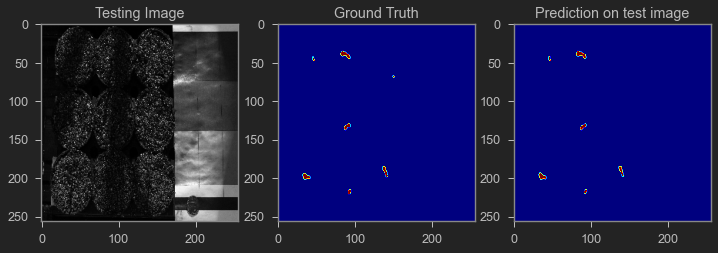

---------------------
FOR MODEL 2: InceptionV3
---------------------


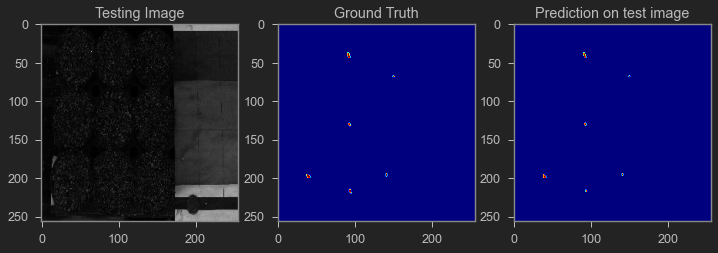

---------------------
FOR MODEL 3: VGG19
---------------------


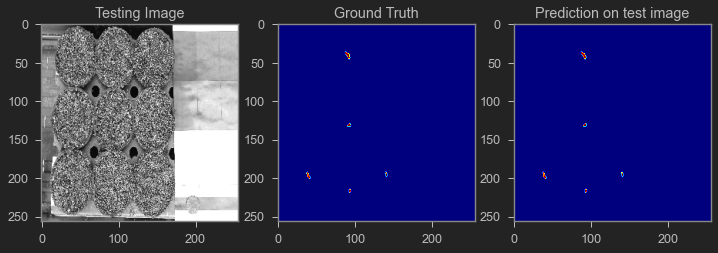

In [63]:
#Test some random images

fg_color = 'black'
bg_color = 'white'
#i=0
print("---------------------")
print("FOR MODEL 1: SEResNet18")
print("---------------------")


test_img_number1 = random.randint(0, len(X_test1)-1)
test_img1 = X_test1[test_img_number1]
ground_truth1=y_test[test_img_number1]
test_img_input1=np.expand_dims(test_img1, 0)

test_img_input1 = preprocess_input1(test_img_input1)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
#test_prediction1 = (model1.predict(test_img_input1)[0,:,:,0] > 0.8).astype(np.uint8)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Testing Image')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(test_img1[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Ground Truth')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Ground Truth')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(ground_truth1[:,:,0], cmap='jet')


plt.subplot(233)
plt.title('Prediction on test image')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Prediction on test image')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(test_prediction1, cmap='jet')
plt.show()


print("---------------------")
print("FOR MODEL 2: InceptionV3")
print("---------------------")
test_img_number2 = random.randint(0, len(X_test2)-1)
test_img2 = X_test[test_img_number2]
ground_truth2=y_test[test_img_number2]
test_img_input2=np.expand_dims(test_img2, 0)

test_img_input2 = preprocess_input2(test_img_input2)

test_pred2 = model2.predict(test_img_input2)
test_prediction2 = np.argmax(test_pred2, axis=3)[0,:,:]
#test_prediction2 = (model2.predict(test_img_input2)[0,:,:,0] > 0.8).astype(np.uint8)
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Testing Image')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(test_img2[:,:,0],cmap='gray')

plt.subplot(232)
plt.title('Ground Truth')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Ground Truth')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(ground_truth2[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Prediction on test image')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(test_prediction2, cmap='jet')
plt.show()


print("---------------------")
print("FOR MODEL 3: VGG19")
print("---------------------")
test_img_number3 = random.randint(0, len(X_test3)-1)
test_img3 = X_test[test_img_number3]
ground_truth3=y_test[test_img_number3]
test_img_input3=np.expand_dims(test_img3, 0)

test_img_input3 = preprocess_input3(test_img_input3)

test_pred3 = model3.predict(test_img_input3)
test_prediction3 = np.argmax(test_pred3, axis=3)[0,:,:]
#test_prediction3 = (model3.predict(test_img_input3)[0,:,:,0] > 0.8).astype(np.uint8)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Testing Image')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(test_img3[:,:,0],cmap='gray')

plt.subplot(232)
plt.title('Ground Truth')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Ground Truth')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(ground_truth3[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Prediction on test image')        
plt.setp(title_obj, color=fg_color)'''
plt.imshow(test_prediction3, cmap='jet')
plt.show()

# Custom Weighted Ensemble

In [37]:
d=[]
D=0
k=[]
sum_k=0
opt_weights=[]
for iou in acc:
    print(iou)
    loss = 1-iou
    d.append(loss)
    D += loss**2
print(d,D)
for loss in d:
    k.append(loss**2/D)
    sum_k += D/loss**2
print(k,sum_k)
for i,value in enumerate(k):
    opt_weights.append((1/value**3)/sum_k)
print(opt_weights)

0.8897809
0.8992801
0.90195376
[0.11021912097930908, 0.10071992874145508, 0.09804624319076538] 0.03190582447895807
[0.38075350904858646, 0.31795147786806455, 0.301295013083349] 9.090511202184011
[1.9928744999570942, 3.422387253898575, 4.02194255468765]


In [38]:
pred1 = model1.predict(X_test1)
pred2 = model2.predict(X_test2)
pred3 = model3.predict(X_test3)

preds = np.array([pred1,pred2,pred3])

weights = opt_weights

weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_preds = np.argmax(weighted_preds, axis=3)
y_pred1_argmax=np.argmax(pred1, axis=3)
y_pred2_argmax=np.argmax(pred2, axis=3)
y_pred3_argmax=np.argmax(pred3, axis=3)

n_classes = 2
IOU1 = MeanIoU(num_classes=n_classes)  
IOU2 = MeanIoU(num_classes=n_classes)  
IOU3 = MeanIoU(num_classes=n_classes)  
IOU_weighted = MeanIoU(num_classes=n_classes)  

IOU1.update_state(y_test[:,:,:,0], y_pred1_argmax)
IOU2.update_state(y_test[:,:,:,0], y_pred2_argmax)
IOU3.update_state(y_test[:,:,:,0], y_pred3_argmax)
IOU_weighted.update_state(y_test[:,:,:,0], weighted_ensemble_preds)


print('IoU Score for model1 = ', IOU1.result().numpy())
print('IoU Score for model2 = ', IOU2.result().numpy())
print('IoU Score for model3 = ', IOU3.result().numpy())
print('IoU Score for weighted ensemble = ', IOU_weighted.result().numpy())
###########################################

IoU Score for model1 =  0.8897809
IoU Score for model2 =  0.8992801
IoU Score for model3 =  0.90195376
IoU Score for weighted ensemble =  0.9062407


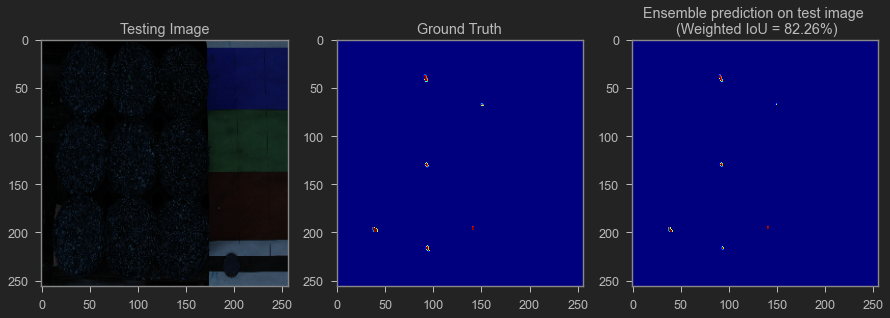

In [64]:
#Predict on a few test image
test_img_number = random.randint(0,len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

models = [model1, model2, model3]

test_img_input1 = preprocess_input1(test_img_input)
test_img_input2 = preprocess_input2(test_img_input)
test_img_input3 = preprocess_input3(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_pred2 = model2.predict(test_img_input2)
test_pred3 = model3.predict(test_img_input3)

test_preds=np.array([test_pred1, test_pred2, test_pred3])

weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0),(0)))
weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=3)[0,:,:]

IOU_wted = MeanIoU(num_classes=n_classes)
IOU_wted.update_state(ground_truth[:,:,0], weighted_ensemble_test_prediction)
#print("IoU = ",IOU_wted.result().numpy())

plt.figure(figsize=(15, 11))
plt.subplot(131)
plt.title('Testing Image')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Testing Image')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(test_img)

plt.subplot(132)
plt.title('Ground Truth')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title('Ground Truth')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(133)
plt.title(f'Ensemble prediction on test image \n (Weighted IoU = {round(IOU_wted.result().numpy()*100,2)}%)')
'''ax = plt.gca()
ax.tick_params(axis='x', colors=fg_color)
ax.tick_params(axis='y', colors=fg_color)
title_obj = plt.title(f'Ensemble prediction on test image \n (Weighted IoU = {round(IOU_wted.result().numpy()*100,2)}%)')            
plt.setp(title_obj, color=fg_color)'''
plt.imshow(ground_truth[:,:,0], cmap='jet')
#plt.title(f'Ensemble prediction on test image \n (Weighted IoU = {round(IOU_wted.result().numpy()*100,2)}%)')
plt.imshow(weighted_ensemble_test_prediction, cmap='jet')
plt.show()

In [40]:
np.unique(ground_truth)

array([0, 1], dtype=int64)

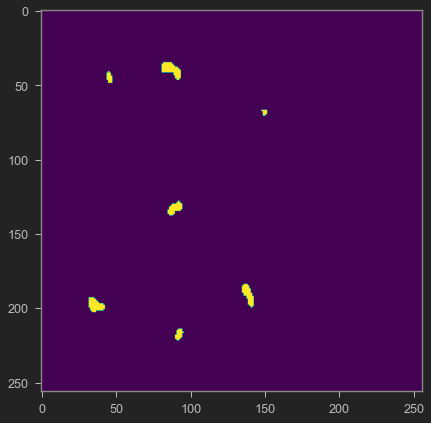

In [41]:
test_img_mask = cv2.imread('maize/masks/IMG_4006.JPG',0)
test_img_mask = cv2.resize(test_img_mask, (size_x,size_y))

test_img_mask = (test_img_mask>20).astype(int)
plt.imshow(test_img_mask)

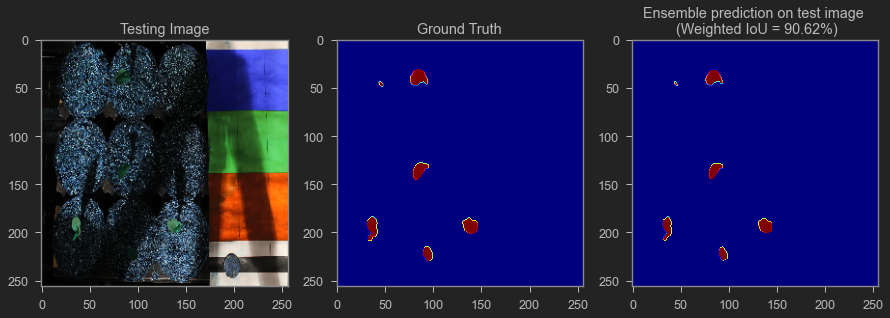

In [42]:
test_img = cv2.imread('maize/images/IMG_5510.png',1)
test_img = cv2.resize(test_img, (size_x,size_y))
#plt.imshow(test_img)

test_img_mask = cv2.imread('maize/masks/IMG_5510.JPG',0)
test_img_mask = cv2.resize(test_img_mask, (size_x,size_y))
test_img_mask = (test_img_mask>20).astype(int)
ground_truth = np.expand_dims(test_img_mask,axis=2)
#plt.imshow(test_img_mask)
test_img_norm = test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

models = [model1, model2, model3]

test_img_input1 = preprocess_input1(test_img_input)
test_img_input2 = preprocess_input2(test_img_input)
test_img_input3 = preprocess_input3(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_pred2 = model2.predict(test_img_input2)
test_pred3 = model3.predict(test_img_input3)

test_preds=np.array([test_pred1, test_pred2, test_pred3])

weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0),(0)))
weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=3)[0,:,:]

IOU_wted = MeanIoU(num_classes=n_classes)
IOU_wted.update_state(ground_truth[:,:,0], weighted_ensemble_test_prediction)
#print("IoU = ",IOU_wted.result().numpy())

plt.figure(figsize=(15, 11))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(133)
plt.title(f'Ensemble prediction on test image \n (Weighted IoU = {round(IOU_wted.result().numpy()*100,2)}%)')
fig=plt.imshow(weighted_ensemble_test_prediction, cmap='jet')
plt.show()

## Results

In [43]:
y_pred1_argmax=np.argmax(pred1, axis=3)
y_pred2_argmax=np.argmax(pred2, axis=3)
y_pred3_argmax=np.argmax(pred3, axis=3)

In [44]:
n_classes = 2
IOU1 = MeanIoU(num_classes=n_classes)  
IOU2 = MeanIoU(num_classes=n_classes)  
IOU3 = MeanIoU(num_classes=n_classes)  
IOU_weighted = MeanIoU(num_classes=n_classes)  

IOU1.update_state(y_test[:,:,:,0], y_pred1_argmax)
IOU2.update_state(y_test[:,:,:,0], y_pred2_argmax)
IOU3.update_state(y_test[:,:,:,0], y_pred3_argmax)
IOU_weighted.update_state(y_test[:,:,:,0], weighted_ensemble_preds)


print('IOU Score for model1 = ', IOU1.result().numpy())
print('IOU Score for model2 = ', IOU2.result().numpy())
print('IOU Score for model3 = ', IOU3.result().numpy())
print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())
###########################################

IOU Score for model1 =  0.8897809
IOU Score for model2 =  0.8992801
IOU Score for model3 =  0.90195376
IOU Score for weighted average ensemble =  0.9062407


In [45]:
%%time
a=5
df = pd.DataFrame([])
for w1 in tqdm(range(1, a)):
    for w2 in range(1,a):
        for w3 in range(1,a):
            wts = [w1/10.,w2/10.,w3/10.]
            
            IOU_wted = MeanIoU(num_classes=n_classes) 
            wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds, axis=3)
            IOU_wted.update_state(y_test[:,:,:,0], wted_ensemble_pred)
            print("Now predicting for weights : [", w1/10., w2/10., w3/10., "] : IoU = ", IOU_wted.result().numpy())
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'IoU': IOU_wted.result().numpy()}, index=[0]), ignore_index=True)
            
max_iou_row = df.iloc[df['IoU'].idxmax()]
print("Max IoU of ", max_iou_row[3], " obained with w1 = ", max_iou_row[0], " w2 = ", max_iou_row[1], " and w3 = ", max_iou_row[2])         

            

  0%|          | 0/4 [00:00<?, ?it/s]

Now predicting for weights : [ 0.1 0.1 0.1 ] : IoU =  0.90430397
Now predicting for weights : [ 0.1 0.1 0.2 ] : IoU =  0.90347
Now predicting for weights : [ 0.1 0.1 0.3 ] : IoU =  0.9032589
Now predicting for weights : [ 0.1 0.1 0.4 ] : IoU =  0.9026394
Now predicting for weights : [ 0.1 0.2 0.1 ] : IoU =  0.90527165
Now predicting for weights : [ 0.1 0.2 0.2 ] : IoU =  0.90486187
Now predicting for weights : [ 0.1 0.2 0.3 ] : IoU =  0.90443516
Now predicting for weights : [ 0.1 0.2 0.4 ] : IoU =  0.9042226
Now predicting for weights : [ 0.1 0.3 0.1 ] : IoU =  0.9012681
Now predicting for weights : [ 0.1 0.3 0.2 ] : IoU =  0.90520656
Now predicting for weights : [ 0.1 0.3 0.3 ] : IoU =  0.9042383
Now predicting for weights : [ 0.1 0.3 0.4 ] : IoU =  0.90471363
Now predicting for weights : [ 0.1 0.4 0.1 ] : IoU =  0.9021543
Now predicting for weights : [ 0.1 0.4 0.2 ] : IoU =  0.9014763
Now predicting for weights : [ 0.1 0.4 0.3 ] : IoU =  0.90520656
Now predicting for weights : [ 0.1 

In [46]:
opt_weights = [max_iou_row[0],max_iou_row[1],max_iou_row[2]]
opt_weighted_preds = np.tensordot(preds, opt_weights, axes=((0),(0)))
opt_weighted_ensemble_preds = np.argmax(opt_weighted_preds,axis=3)

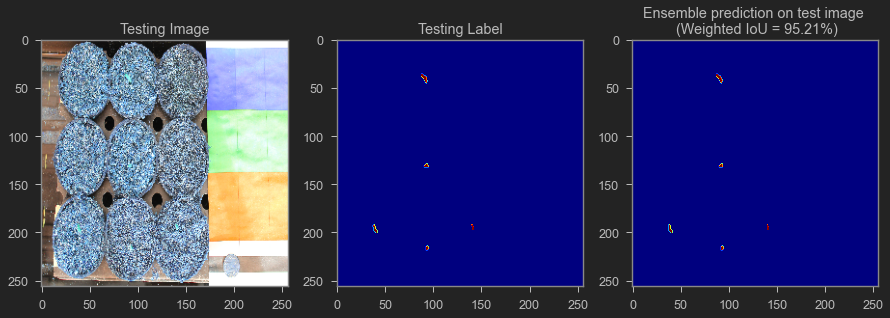

In [47]:
#Predict on a few image
test_img_number = random.randint(0,len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

models = [model1, model2, model3]

test_img_input1 = preprocess_input1(test_img_input)
test_img_input2 = preprocess_input2(test_img_input)
test_img_input3 = preprocess_input3(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_pred2 = model2.predict(test_img_input2)
test_pred3 = model3.predict(test_img_input3)

test_preds=np.array([test_pred1, test_pred2, test_pred3])

weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0),(0)))
weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=3)[0,:,:]

IOU_wted = MeanIoU(num_classes=n_classes)
IOU_wted.update_state(ground_truth[:,:,0], weighted_ensemble_test_prediction)

plt.figure(figsize=(15, 11))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(133)
plt.title(f'Ensemble prediction on test image \n (Weighted IoU = {round(IOU_wted.result().numpy()*100,2)}%)')
plt.imshow(weighted_ensemble_test_prediction, cmap='jet')
plt.show()

In [48]:
import cv2
import matplotlib.pyplot as plt
#import nose.tools
import numpy as np
import scipy.misc
import scipy.ndimage
import skimage.filters
import sklearn.metrics
# Optional, added to ignore scipy read warnings
import warnings

warnings.simplefilter('ignore')


In [49]:
def _assert_valid_lists(groundtruth_list, predicted_list):
    assert len(groundtruth_list) == len(predicted_list)
    for unique_element in np.unique(groundtruth_list).tolist():
        assert unique_element in [0, 1]


def _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [1]


def _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == np.unique(predicted_list).tolist() == [0]


def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """
    Return confusion matrix elements covering edge cases
    :param groundtruth_list list of groundtruth elements
    :param predicted_list list of predicted elements
    :return returns confusion matrix elements i.e TN, FP, FN, TP in that order and as floats
    returned as floats to make it feasible for float division for further calculations on them
    """
    _assert_valid_lists(groundtruth_list, predicted_list)

    if _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(groundtruth_list))

    elif _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        tn, fp, fn, tp = np.float64(len(groundtruth_list)), 0, 0, 0

    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
        tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp



def _all_class_0_predicted_as_class_1(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == [0] and np.unique(predicted_list).tolist() == [1]


def _all_class_1_predicted_as_class_0(groundtruth_list, predicted_list):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return np.unique(groundtruth_list).tolist() == [1] and np.unique(predicted_list).tolist() == [0]


def _mcc_denominator_zero(tn, fp, fn, tp):
    _assert_valid_lists(groundtruth_list, predicted_list)
    return (tn == 0 and fn == 0) or (tn == 0 and fp == 0) or (tp == 0 and fp == 0) or (tp == 0 and fn == 0)


def get_f1_score(groundtruth_list, predicted_list):
    """
    Return f1 score covering edge cases
    :param groundtruth_list list of groundtruth elements
    :param predicted_list list of predicted elements
    :return returns f1 score
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        f1_score = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        f1_score = 1
    else:
        f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score


def get_mcc(groundtruth_list, predicted_list):
    """
    Return mcc covering edge cases
    :param groundtruth_list list of groundtruth elements
    :param predicted_list list of predicted elements
    :return returns mcc
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    if _all_class_0_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        mcc = 1
    elif _all_class_1_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        mcc = 1
    elif _all_class_1_predicted_as_class_0(groundtruth_list, predicted_list) is True:
        mcc = -1
    elif _all_class_0_predicted_as_class_1(groundtruth_list, predicted_list) is True:
        mcc = -1
    elif _mcc_denominator_zero(tn, fp, fn, tp) is True:
        mcc = -1
    else:
        mcc = ((tp * tn) - (fp * fn)) / (
            np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

    return mcc


def get_accuracy(groundtruth_list, predicted_list):
    """
    Return accuracy
    :param groundtruth_list list of elements
    :param predicted_list list of elements
    :return returns accuracy
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total

    return accuracy


def get_validation_metrics(groundtruth_list, predicted_list):
    """
    Return validation metrics dictionary with accuracy, f1 score, mcc after
    comparing ground truth and predicted image
    :param groundtruth_list list of elements
    :param predicted_list list of elements
    :return returns a dictionary with accuracy, f1 score, and mcc as keys
    one could add other stats like FPR, FNR, TP, TN, FP, FN etc
    """
    _assert_valid_lists(groundtruth_list, predicted_list)
    validation_metrics = {}

    validation_metrics["accuracy"] = get_accuracy(groundtruth_list, predicted_list)
    validation_metrics["f1_score"] = get_f1_score(groundtruth_list, predicted_list)
    validation_metrics["mcc"] = get_mcc(groundtruth_list, predicted_list)
    validation_metrics["f1-score"] = get_f1_score(groundtruth_list, predicted_list)

    return validation_metrics

In [50]:
groundtruth_list = ground_truth[:,:,0].flatten().tolist()
predicted_list = weighted_ensemble_test_prediction.flatten().tolist()
validation_metrics = get_validation_metrics(groundtruth_list,predicted_list)
validation_metrics

{'accuracy': 0.9998626708984375,
 'f1_score': 0.9497206703910615,
 'mcc': 0.9500236801040753,
 'f1-score': 0.9497206703910615}

In [51]:
np.unique(ground_truth)

array([0, 1], dtype=int64)

In [52]:
max(groundtruth_list)

1

In [53]:
weighted_ensemble_test_prediction

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [54]:
np.unique(ground_truth)

array([0, 1], dtype=int64)

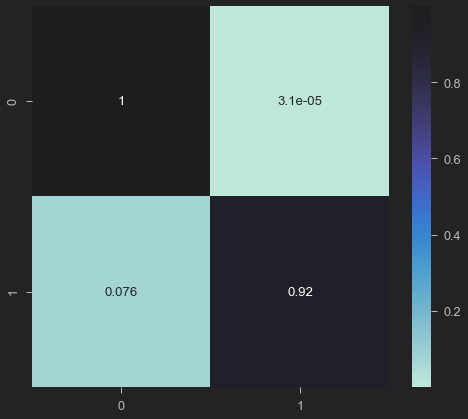

In [55]:
import seaborn as sns
cf=get_confusion_matrix_elements(groundtruth_list,predicted_list)
cf_arr=np.array(cf).reshape(-1, 2)

cm = cf_arr.astype('float') / cf_arr.sum(axis=1)[:, np.newaxis]
s=sns.heatmap(cm, annot=True,center=1) #cmap="YlGnBu")
s=s.get_figure()

In [56]:
s.savefig('1.png', transparent=True)

In [57]:
np.unique(ground_truth)

array([0, 1], dtype=int64)

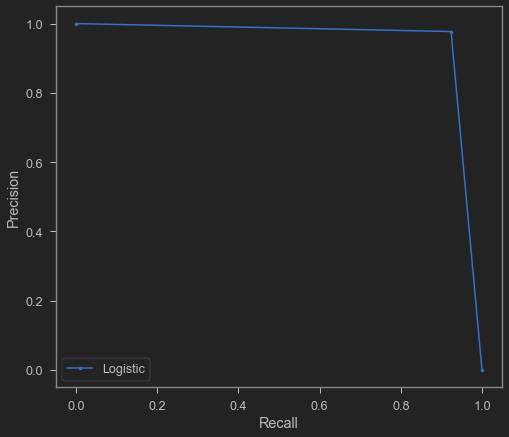

In [58]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

precision, recall, _ = precision_recall_curve(groundtruth_list, predicted_list)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show tzhe legend
pyplot.legend()
# show the plot
pyplot.show()

In [59]:
np.unique(ground_truth)

array([0, 1], dtype=int64)

Cyan - TP
Magenta - FP
Red - FN
Black - TN


Text(0.5, 1.0, 'Weighted IoU = 95.21%')

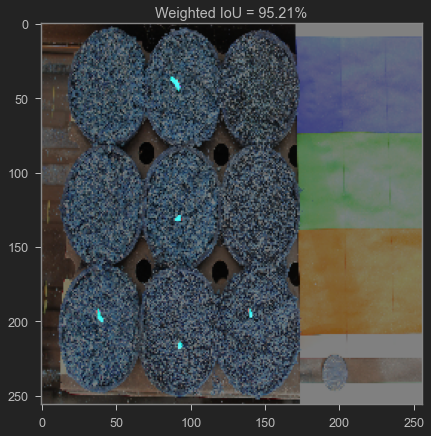

In [60]:
def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    """
    Returns a dictionary of 4 boolean numpy arrays containing True at TP, FP, FN, TN.
    """
    confusion_matrix_arrs = {}

    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs["tp"] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs["tn"] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs["fp"] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs["fn"] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs

def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, alpha, colors):
    """
    Returns overlay the 'image' with a color mask where TP, FP, FN, TN are
    each a color given by the 'colors' dictionary
    """
    #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)
    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb
    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)

alpha = 0.5
confusion_matrix_colors = {
   'tp': (0, 255, 255),  #cyan
   'fp': (255, 0, 255),  #magenta
   'fn': (255, 0, 0),  #red
   'tn': (0, 0, 0)     #black
   }
validation_mask = get_confusion_matrix_overlaid_mask(test_img, ground_truth[:,:,0], weighted_ensemble_test_prediction, alpha, confusion_matrix_colors)
print('Cyan - TP')
print('Magenta - FP')
print('Red - FN')
print('Black - TN')
plt.imshow(validation_mask)
#plt.title(f'Ensemble prediction on test image \n (Weighted IoU = {round(IOU_wted.result().numpy()*100,2)}%)')
plt.title(f'Weighted IoU = {round(IOU_wted.result().numpy()*100,2)}%')


In [61]:
precision, recall

(array([0.00140381, 0.97701149, 1.        ]),
 array([1.        , 0.92391304, 0.        ]))

In [62]:
precision

array([0.00140381, 0.97701149, 1.        ])